<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal LLM using Google's Gemini model for image understanding and build Retrieval Augmented Generation with LlamaIndex

In this notebook, we show how to use Google's Gemini Vision models for image understanding.

First, we show several functions we are now supporting for Gemini:
* `complete` (both sync and async): for a single prompt and list of images
* `chat` (both sync and async): for multiple chat messages
* `stream complete` (both sync and async): for steaming output of complete
* `stream chat` (both sync and async): for steaming output of chat

For the 2nd part of this notebook, we try to use `Gemini` + `Pydantic` to parse structured information for images from Google Maps.
* Define the desired Pydantic class with attribution fields
* Let `gemini-pro-vision` model understand each image and output structured results

For the the 3rd part of this notebook, we propose using Gemini & LlamaIndex to build a simple `Retrieval Augmented Generation` Flow for a small Google Maps restaurant dataset.
* Build vector index based on the structured outputs from Step 2
* Using the `gemini-pro` model to synthesize the results and recommends restaurants based on user query.

Note: `google-generativeai` is only available for certain countries and regions.

In [1]:
!pip install llama-index 'google-generativeai>=0.3.0' matplotlib qdrant_client --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.1/990.1 kB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.7/598.7 kB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 128.2 MB/s eta 0:00:0000:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 915.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 161.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 132.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 11.3 MB/s eta 0:00:00
  Attempting u

##  Use Gemini to understand Images from URLs

In [2]:
import os

#GOOGLE_API_KEY = os.getenv('genimi_api_token')  # add your GOOGLE API key here
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY = os.getenv('gemini_api_token')

## Initialize `GeminiMultiModal` and Load Images from URLs

In [37]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal

from llama_index.multi_modal_llms.generic_utils import (
    load_image_urls,
)

image_urls = [
    #"https://storage.googleapis.com/generativeai-downloads/data/scene.jpg",
    "https://miro.medium.com/v2/resize:fit:1400/format:webp/1*BJXLT70TOu5x-Ain4GNUHQ.png",
    #"https://theodora.com/wfb/photos/russia/street_scene_moscow_russia_photo_gov.jpg", #Street scene, Moscow Source: Moscow municipal government, used with permission.
    # Add yours here!
]

image_documents = load_image_urls(image_urls)

gemini_pro = GeminiMultiModal(model="models/gemini-pro")

In [38]:
image_documents

[ImageDocument(id_='697857de-0187-4141-998a-53f729e457b9', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, hash='44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a', text='', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path=None, image_url='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*BJXLT70TOu5x-Ain4GNUHQ.png', text_embedding=None)]

https://miro.medium.com/v2/resize:fit:1400/format:webp/1*BJXLT70TOu5x-Ain4GNUHQ.png


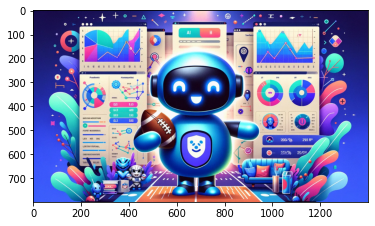

In [39]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

img_response = requests.get(image_urls[0])
print(image_urls[0])
img = Image.open(BytesIO(img_response.content))
#img2 = Image.open("/tmp/mmRAGi.png")
plt.imshow(img)

### Complete a prompt with a bunch of images

In [40]:
complete_response = gemini_pro.complete(
    #prompt="Identify the city where this photo was taken and give detail processes on how did you reach the conclusion.",
    prompt='Identify the generated image and describe the meaning with details context. You can imaginate if needed.',
    image_documents=image_documents,
)

In [41]:
print(complete_response)

 The image shows a blue robot holding a football. The background is a stadium. There are many graphs and charts on the walls. The robot is smiling and looks happy. I think the image is about a robot that is playing football. The graphs and charts on the walls are showing the data about the game. The robot is happy because it is winning the game.


### Steam Complete a prompt with a bunch of images

In [42]:
stream_complete_response = gemini_pro.stream_complete(
    prompt="Please create a comprehensive prompt text for an image generation engine input to generate a new image closly match the sample image.",
    image_documents=image_documents,
)

In [43]:
for r in stream_complete_response:
    print(r.text, end="")

 A blue robot stands in a room with a football in its hand. The robot is wearing a white helmet and a blue jersey. The room is decorated with football-themed posters and there is a football field in the background. The robot is smiling and has a happy expression on its face.

### Async Complete

In [11]:
response_acomplete = await gemini_pro.acomplete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

In [12]:
print(response_acomplete)

 The image shows a busy street in Moscow with many cars parked on either side of the road. There are also people walking on the street and a bus driving down the road. The buildings on either side of the street are tall and have a lot of windows. The street is lined with trees and there are some clouds in the sky.


### Async Steam Complete

In [13]:
response_astream_complete = await gemini_pro.astream_complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

In [15]:
async for delta in response_astream_complete:
    print(delta.text, end="")

## Complete with Two images

In [18]:
image_urls = [
    "https://www.sportsnet.ca/wp-content/uploads/2023/11/CP1688996471-1040x572.jpg",
    "https://res.cloudinary.com/hello-tickets/image/upload/c_limit,f_auto,q_auto,w_1920/v1640835927/o3pfl41q7m5bj8jardk0.jpg",
    "https://www.cleverfiles.com/howto/wp-content/uploads/2018/03/minion.jpg",
]

image_documents_1 = load_image_urls(image_urls)

response_multi = gemini_pro.complete(
    prompt="Describe the context all all images with details. is there any relationship among those images?",
    image_documents=image_documents_1,
)
print(response_multi)

 The first image shows Lionel Messi, a famous football player, holding a golden ball. The second image shows the Colosseum, an ancient amphitheater in Rome, Italy. The third image shows two yellow cartoon characters from the Minions movie franchise.

There is no direct relationship among those images. However, they are all related to the concept of "entertainment". Messi is a famous athlete who entertains people with his football skills. The Colosseum was an ancient entertainment venue where people watched gladiatorial contests and other spectacles. The Minions are cartoon characters who entertain people with their funny antics.


## 2nd Part: `Gemini` + `Pydantic` for Structured Output Parsing from an Image

* Leveraging Gemini for the image reasoning
* Use Pydantic program to generate structured output from the image reasoning results of Gemini

In [19]:
import google.generativeai as genai

genai.configure(
    api_key=GOOGLE_API_KEY,
    client_options={"api_endpoint": "generativelanguage.googleapis.com"},
)

List available Gemini Models from `google.generativeai`.
Make sure your API key has access to belowing models

In [20]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-pro
models/gemini-pro-vision


### Download example images for Gemini to understand

In [21]:
from pathlib import Path

input_image_path = Path("google_restaurants")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

In [22]:
!wget "https://docs.google.com/uc?export=download&id=1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg" -O ./google_restaurants/miami.png
!wget "https://docs.google.com/uc?export=download&id=1dYZy17bD6pSsEyACXx9fRMNx93ok-kTJ" -O ./google_restaurants/orlando.png
!wget "https://docs.google.com/uc?export=download&id=1ShPnYVc1iL_TA1t7ErCFEAHT74-qvMrn" -O ./google_restaurants/sf.png
!wget "https://docs.google.com/uc?export=download&id=1WjISWnatHjwL4z5VD_9o09ORWhRJuYqm" -O ./google_restaurants/toronto.png

--2023-12-19 16:49:51--  https://docs.google.com/uc?export=download&id=1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg
Resolving docs.google.com (docs.google.com)... 172.253.63.138, 172.253.63.100, 172.253.63.113, ...
Connecting to docs.google.com (docs.google.com)|172.253.63.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a6f13b6ci0qi46o03g91gtd4mb32f7mg/1703004525000/16146658138026472746/*/1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg?e=download&uuid=8673195c-288e-4e6d-989d-1b7514e4606a [following]
--2023-12-19 16:49:52--  https://doc-00-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a6f13b6ci0qi46o03g91gtd4mb32f7mg/1703004525000/16146658138026472746/*/1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg?e=download&uuid=8673195c-288e-4e6d-989d-1b7514e4606a
Resolving doc-00-5c-docs.googleusercontent.com (doc-00-5c-docs.googleusercontent.com)... 142.251.16.132, 2607:f8b0:

### Define the Pydantic Class for the Structured Parser

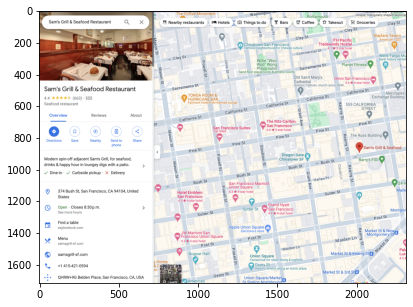

In [24]:
from pydantic import BaseModel
from PIL import Image
import matplotlib.pyplot as plt


class GoogleRestaurant(BaseModel):
    """Data model for a Google Restaurant."""

    restaurant: str
    food: str
    location: str
    category: str
    hours: str
    price: float
    rating: float
    review: str
    description: str
    nearby_tourist_places: str


google_image_url = "./google_restaurants/sf.png"
image = Image.open(google_image_url).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

### Call the Pydantic Program and Generate Structured Output

In [25]:
from llama_index.multi_modal_llms import GeminiMultiModal
from llama_index.program import MultiModalLLMCompletionProgram
from llama_index.output_parsers import PydanticOutputParser

prompt_template_str = """\
    can you summarize what is in the image\
    and return the answer with json format \
"""


def pydantic_gemini(
    model_name, output_class, image_documents, prompt_template_str
):
    gemini_llm = GeminiMultiModal(
        api_key=GOOGLE_API_KEY, model_name=model_name
    )

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response

### Generate the Pydantic Structured Output via Gemini Vision Model

In [26]:
from llama_index import SimpleDirectoryReader

google_image_documents = SimpleDirectoryReader(
    "./google_restaurants"
).load_data()

results = []
for img_doc in google_image_documents:
    pydantic_response = pydantic_gemini(
        "models/gemini-pro-vision",
        GoogleRestaurant,
        [img_doc],
        prompt_template_str,
    )
    # only output the results for miami for example along with image
    if "miami" in img_doc.image_path:
        for r in pydantic_response:
            print(r)
    results.append(pydantic_response)

('restaurant', 'La Mar by Gaston Acurio')
('food', 'South American')
('location', '500 Brickell Key Dr, Miami, FL 33131')
('category', 'Restaurant')
('hours', 'Open ⋅ Closes 11 PM')
('price', 4.0)
('rating', 4.4)
('review', '4.4 (2,104)')
('description', 'Chic waterfront find offering Peruvian & fusion fare, plus bars for cocktails, ceviche & anticucho.')
('nearby_tourist_places', 'Brickell Key Park')


ValidationError: 1 validation error for GoogleRestaurant
price
  value is not a valid float (type=type_error.float)

`Observation`:
* Gemini perfectly generates all the meta information we need for the Pydantic class
* It could also recognizes the nearby park from `Google Maps` 

## 3rd Part: Build Multi-Modal RAG for Restaurant Recommendation

Our stack consists of Gemini + LlamaIndex + Pydantic structured output capabilities

### Construct Text Nodes for Building Vector Store. Store metadata and description for each restaurant.

In [27]:
from llama_index.schema import TextNode

nodes = []
for res in results:
    text_node = TextNode()
    metadata = {}
    for r in res:
        # set description as text of TextNode
        if r[0] == "description":
            text_node.text = r[1]
        else:
            metadata[r[0]] = r[1]
    text_node.metadata = metadata
    nodes.append(text_node)

### Using Gemini Embedding for building Vector Store for Dense retrieval. Index Restaurants as nodes into Vector Store

In [28]:
from llama_index import VectorStoreIndex, StorageContext, ServiceContext
from llama_index.embeddings import GeminiEmbedding
from llama_index.llms import Gemini
from llama_index.vector_stores import QdrantVectorStore
from llama_index import StorageContext
import qdrant_client


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini_3")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# Using the embedding model to Gemini
embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)
service_context = ServiceContext.from_defaults(
    llm=Gemini(api_key=GOOGLE_API_KEY), embed_model=embed_model
)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    service_context=service_context,
    storage_context=storage_context,
)

### Using Gemini to synthesize the results and recommend the restaurants to user 

In [30]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
)

response = query_engine.query(
    "recommend a San Francisco restaurant for me and its nearby tourist places"
)
print(response)

For a delightful seafood experience, visit Sam's Grill & Seafood Restaurant at 374 Bush St, San Francisco. After your meal, explore the nearby Chinatown, the oldest and largest Chinatown outside of Asia, a popular tourist destination.
